In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Init Plugin
Init Graph Optimizer
Init Kernel
Tensorflow Version: 2.5.0
Pandas Version: 1.3.5
Numpy Version: 1.19.5
System Version: 3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:07) 
[Clang 11.1.0 ]


In [2]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 300
TRAIN_SPLIT = 1000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 4
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [3]:
df = pd.read_csv('./data1.csv')
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
df.head()

df = df[:10000]

DataFrame Shape: 30030 rows, 69 columns


In [4]:
features_considered = ['npart',
 'tres',
 'T',
 'Z',
 'N2a',
 'OH',
 'H2a',
 'H',
 'H2Oa',
 'COa',
 'CO2a',
 'HCO',
 'CH2O',
 'CH2OH',
 'CH3',
 'CH4a',
 'C2H5',
 'CH3OH',
 'C2H2',
 'C2H3',
 'CH2CO',
 'CH2CHO',
 'CH3CHO',
 'C2H4',
 'C2H6',
 'CH3COCH3',
 'C3H3',
 'A1-C6H6',
 'C5H6',
 'C5H5',
 'C9H8',
 'C9H7',
 'A1CH2-C7H7',
 'A2-C10H8',
 'A1OH-C6H6O',
 'LVG-C6H10O5',
 'HMFU-C6H6O3',
 'C3H4O3',
 'C5H4O2',
 'C2H2O2',
 'HAA-C2H4O2',
 'XYLOSE-C5H8O',
 'C11H12O4',
 'C8H10O3',
 'COUMARYL-C9H',
 'C2H5OH',
 'HCOOH',
 'CH3O',
 'BV2',
 'N2b',
 'C2',
 'C57',
 'C34O',
 'C1',
 'RAD',
 'BV1',
 'H2b',
 'C2O',
 'CO2b',
 'C57O',
 'C34',
 'COb',
 'R1',
 'CH4b',
 'RO',
 'BV3',
 'H2Ob',
 'R2']
 

In [5]:
features = df[features_considered]
features.index = df['Unnamed: 0']

In [8]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)


In [9]:
display(pd.DataFrame(dataset, columns = features.columns, index= features.index).head())

,npart,tres,T,Z,N2a,OH,H2a,H,H2Oa,COa,...,CO2b,C57O,C34,COb,R1,CH4b,RO,BV3,H2Ob,R2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,1073.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.158700,0.163410,...,0.062780,0.0,0.000000e+00,0.163410,0.000000,0.009350,0.038780,0.265810,0.158700,0.000000
1,1.0,0.0,1073.0,0.0,0.0,1.684630e-11,0.000003,1.873640e-11,0.158957,0.163735,...,0.062882,0.0,6.256400e-11,0.163735,0.000011,0.009375,0.038829,0.263476,0.158957,0.001176
2,1.0,0.0,1073.0,0.0,0.0,1.630020e-11,0.000006,1.898560e-11,0.159205,0.164052,...,0.062980,0.0,2.716870e-10,0.164052,0.000022,0.009400,0.038876,0.261218,0.159205,0.002314
3,1.0,0.0,1073.0,0.0,0.0,1.582240e-11,0.000008,1.919680e-11,0.159446,0.164362,...,0.063075,0.0,6.465540e-10,0.164362,0.000033,0.009425,0.038920,0.259033,0.159446,0.003415
4,1.0,0.0,1073.0,0.0,0.0,1.540330e-11,0.000011,1.938010e-11,0.159679,0.164665,...,0.063167,0.0,1.196690e-09,0.164665,0.000044,0.009449,0.038963,0.256919,0.159679,0.004480


In [67]:
print(pd.DataFrame(dataset).dtypes)

0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
63    float64
64    float64
65    float64
66    float64
67    float64
Length: 68, dtype: object


In [6]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

In [10]:
def create_time_steps(length):
    return list(range(-length, 0))

In [225]:
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    color = []
    for i in range(len(features.columns)):
        color.append('b')

    for i, (var, c) in enumerate(zip(features.columns, color)):
        print(history[:,i][:10])
        plt.plot(num_in, np.array(history[:,i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
        plt.show()

    plt.legend(loc='upper left')


In [230]:
future_target = 2
past_history = 720
STEP = 6
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:len(dataset[0])], dataset[:,:len(dataset[0])], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:len(dataset[0])], dataset[:, :len(dataset[0])],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [231]:
print (x_train_multi.shape,
       y_train_multi.shape,
       x_val_multi.shape,
       y_val_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target temperature to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(280, 120, 68, 1, 1)
(280, 2, 68, 1, 1)
(8278, 120, 68, 1, 1)
(8278, 2, 68, 1, 1)
Single window of past history : (120, 68, 1, 1)
Target temperature to predict : (2, 68, 1, 1)


In [232]:
BATCH_SIZE = 64

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


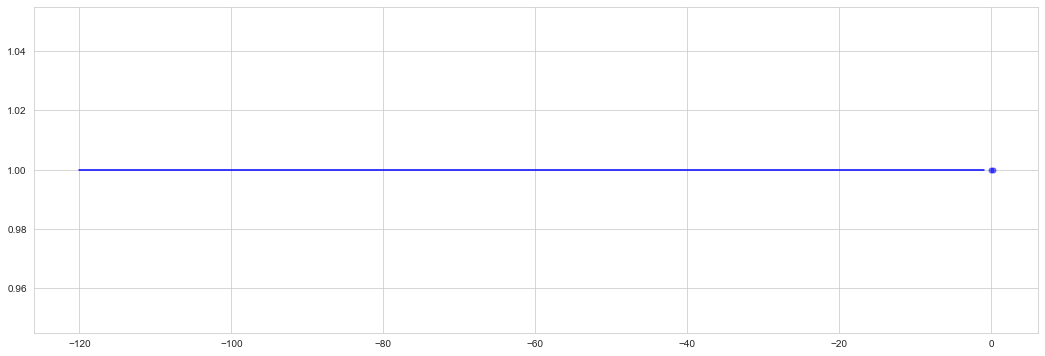

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


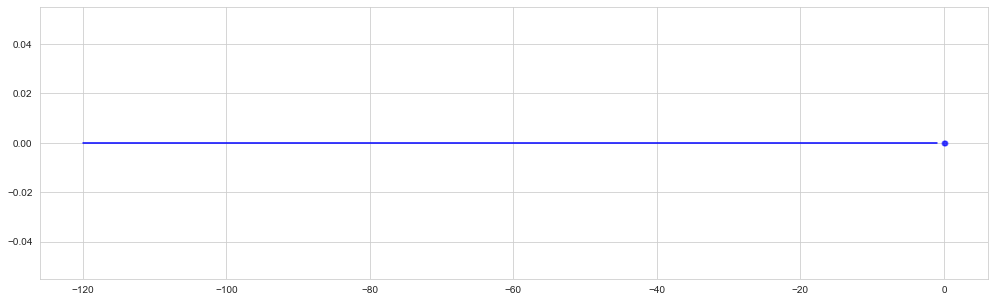

[1073. 1073. 1073. 1073. 1073. 1073. 1073. 1073. 1073. 1073.]


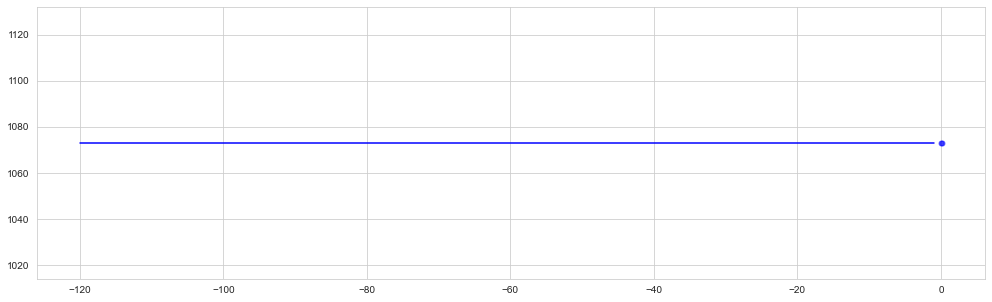

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


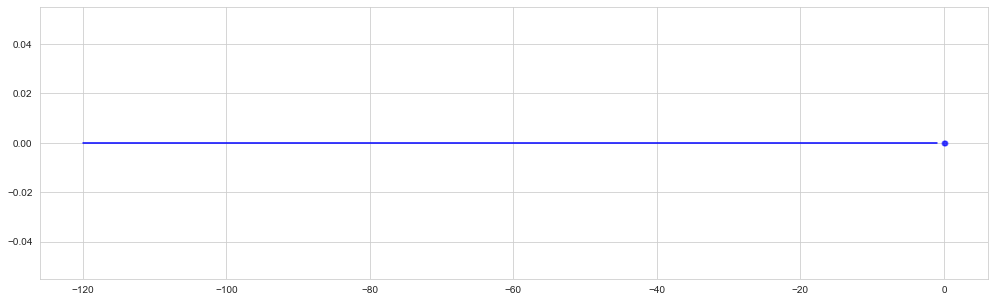

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


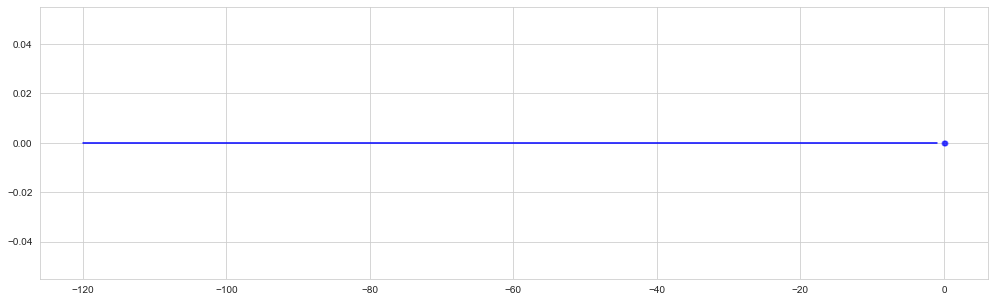

[2.61128e-12 1.42585e-11 1.25778e-11 1.17297e-11 1.12591e-11 1.09764e-11
 1.07918e-11 1.06593e-11 1.05543e-11 1.04635e-11]


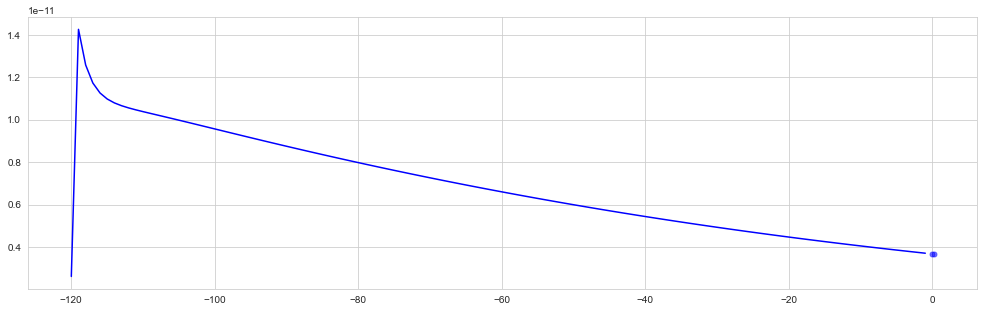

[1.53097e-03 1.34601e-05 3.11363e-05 4.97741e-05 6.89394e-05 8.83548e-05
 1.07841e-04 1.27284e-04 1.46608e-04 1.65767e-04]


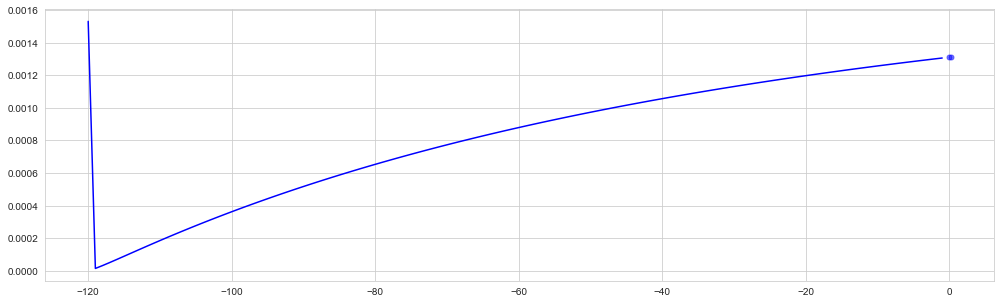

[4.68666e-12 1.80251e-11 1.87785e-11 1.92202e-11 1.94727e-11 1.95995e-11
 1.96402e-11 1.96204e-11 1.95576e-11 1.94636e-11]


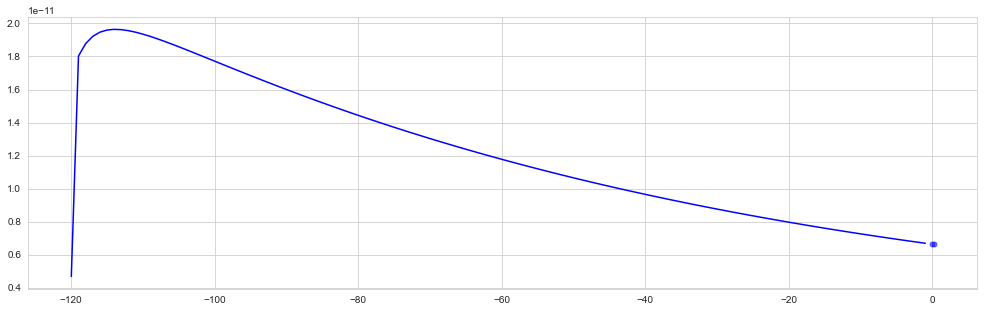

[0.169302 0.152492 0.153722 0.154734 0.155565 0.156247 0.156808 0.157268
 0.157647 0.15796 ]


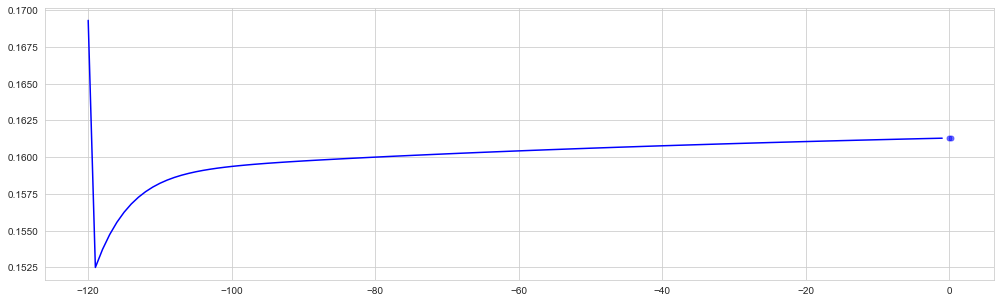

[0.207421 0.183806 0.185647 0.187238 0.188617 0.189819 0.190874 0.191808
 0.192641 0.19339 ]


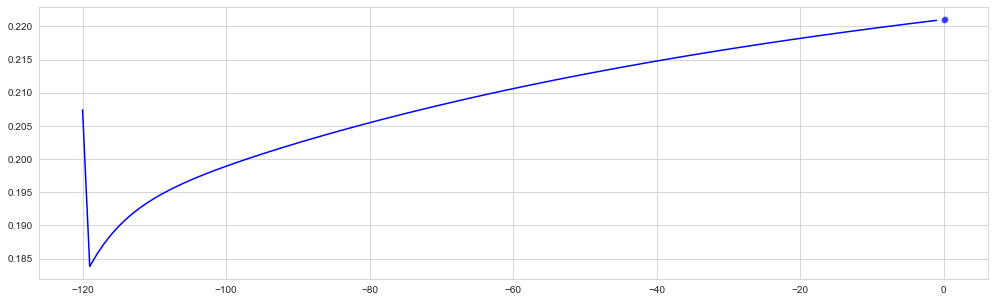

[0.0670191 0.0590435 0.0595206 0.0599132 0.0602358 0.0605009 0.0607188
 0.060898  0.0610457 0.0611677]


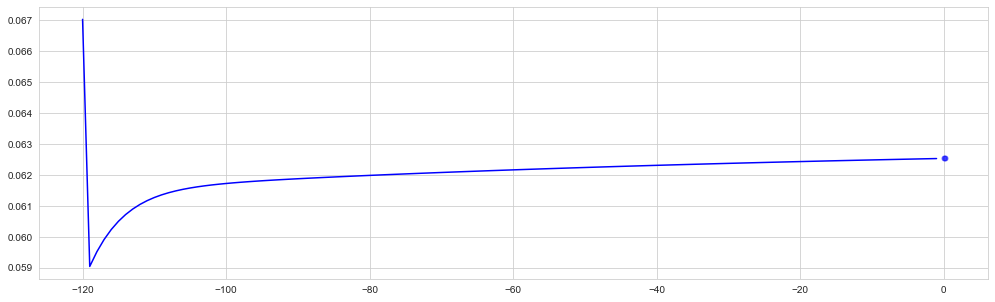

[3.59540e-09 2.01357e-08 2.13644e-08 2.20309e-08 2.23551e-08 2.24631e-08
 2.24337e-08 2.23163e-08 2.21423e-08 2.19316e-08]


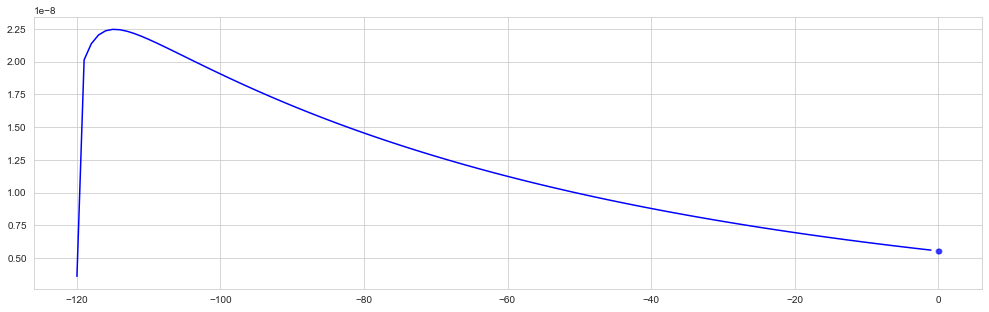

[0.0601752 0.0611664 0.0677826 0.0717688 0.0741541 0.0755627 0.0763729
 0.0768139 0.0770255 0.077093 ]


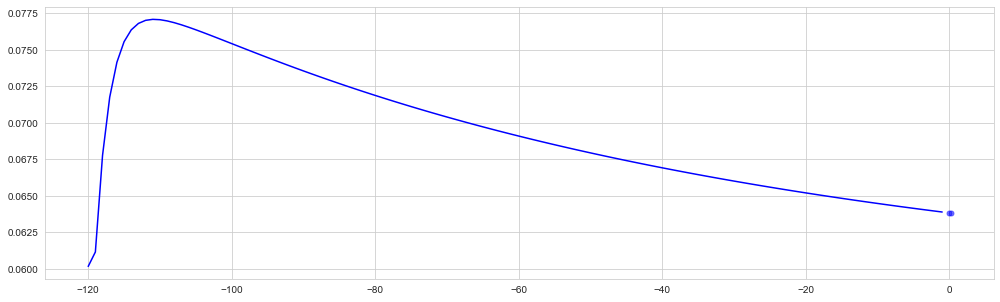

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


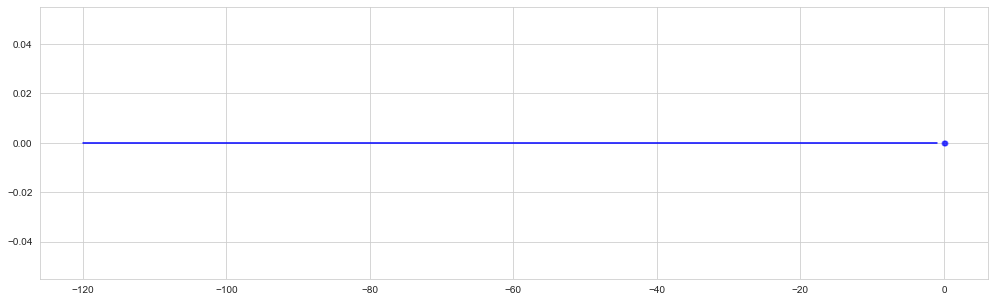

[4.51528e-09 2.53463e-08 2.39733e-08 2.31807e-08 2.26778e-08 2.23254e-08
 2.20524e-08 2.18209e-08 2.16104e-08 2.14101e-08]


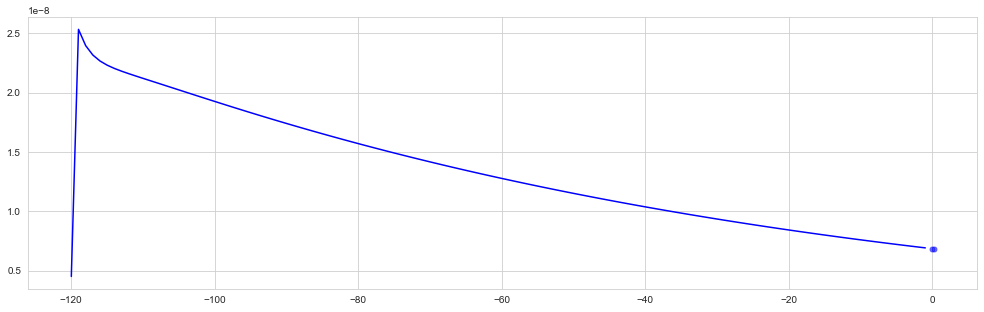

[0.0146296  0.00888912 0.00901875 0.00913579 0.00924219 0.00933963
 0.00942954 0.00951312 0.00959137 0.00966513]


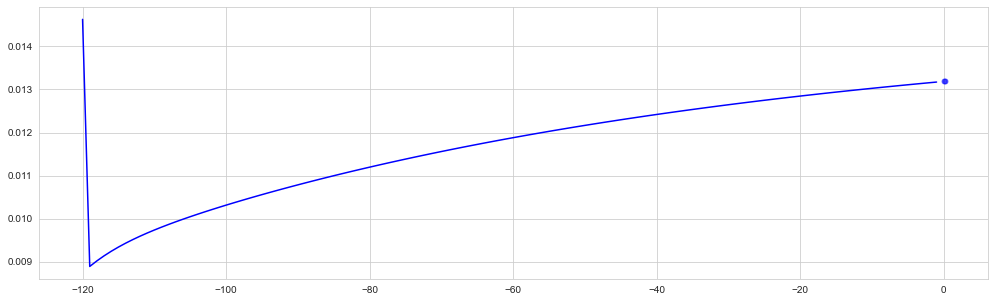

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


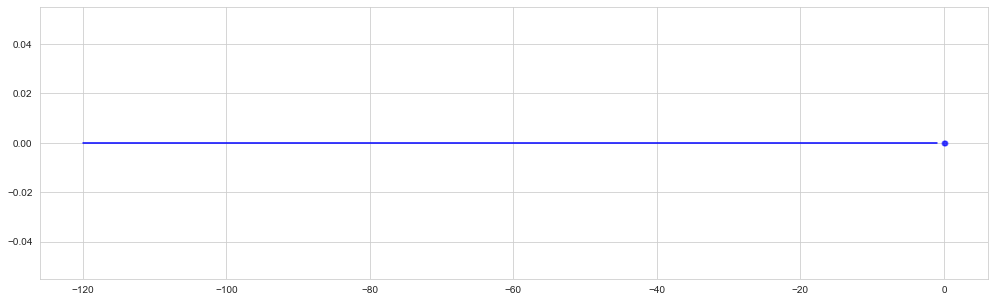

[0.072018  0.0860908 0.0866854 0.0871535 0.0875176 0.0877966 0.0880064
 0.08816   0.0882679 0.0883391]


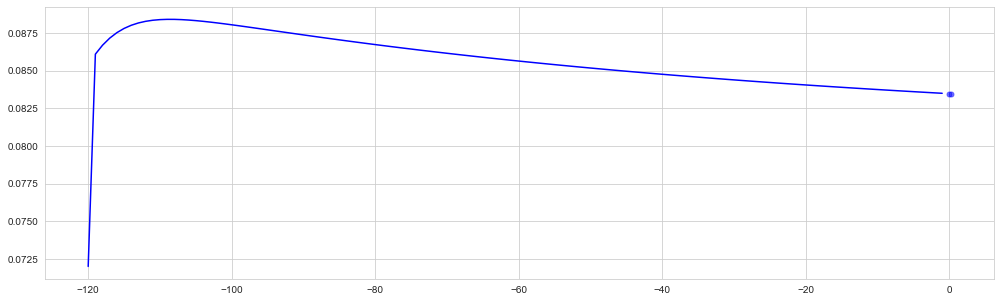

[1.35444e-03 9.68569e-06 2.17753e-05 3.41992e-05 4.68429e-05 5.96260e-05
 7.24902e-05 8.53924e-05 9.83003e-05 1.11190e-04]


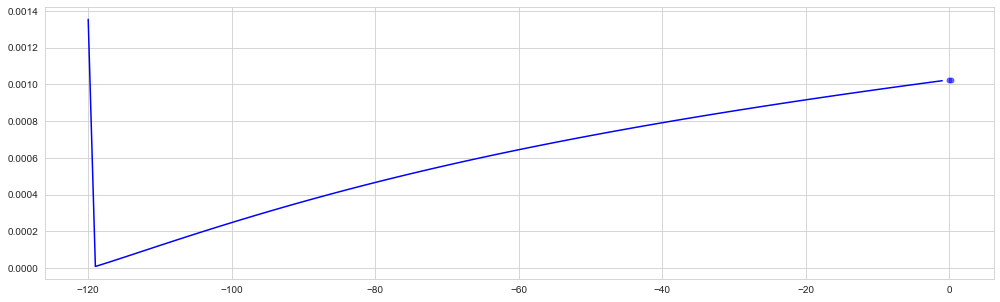

[1.34099e-09 3.34322e-09 3.54477e-09 3.69258e-09 3.80534e-09 3.89297e-09
 3.96183e-09 4.01623e-09 4.05915e-09 4.09275e-09]


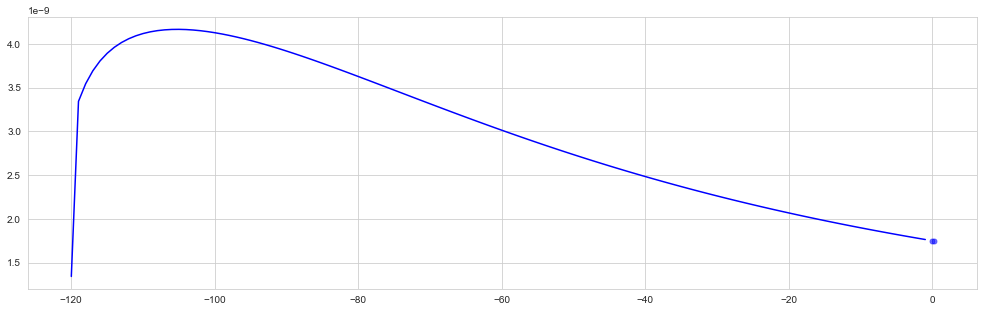

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


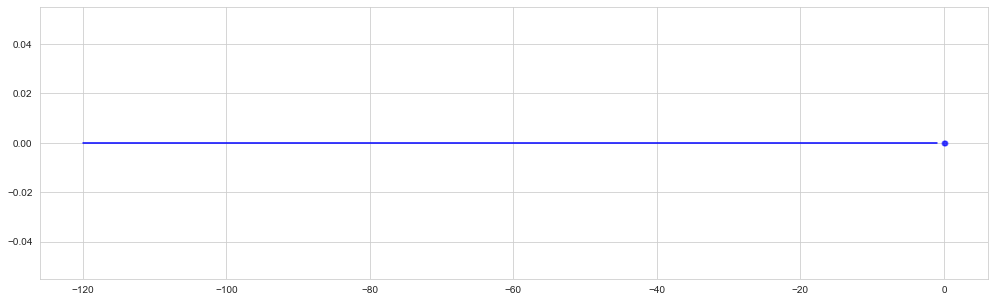

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


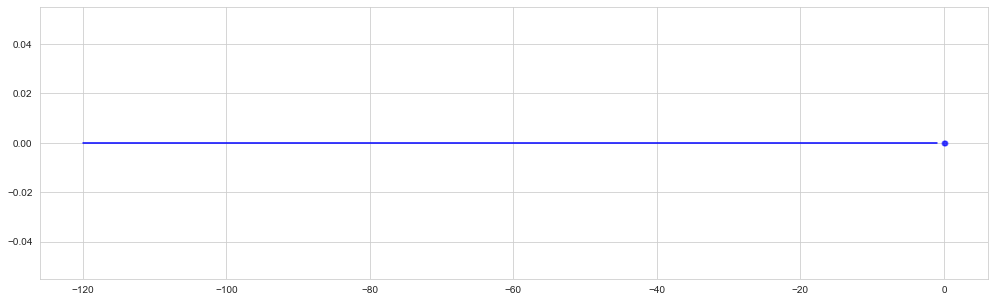

[0.00185109 0.0117101  0.0116557  0.0115848  0.0115005  0.0114059
 0.0113031  0.0111942  0.0110806  0.0109637 ]


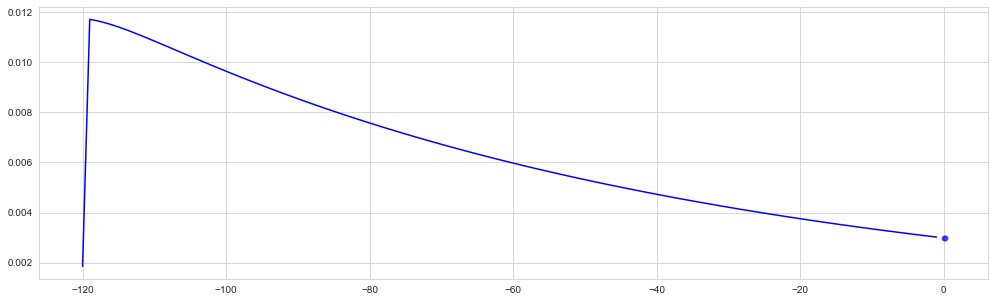

[0.0724311 0.0703574 0.0708534 0.0712461 0.0715538 0.0717919 0.0719732
 0.0721084 0.0722061 0.0722736]


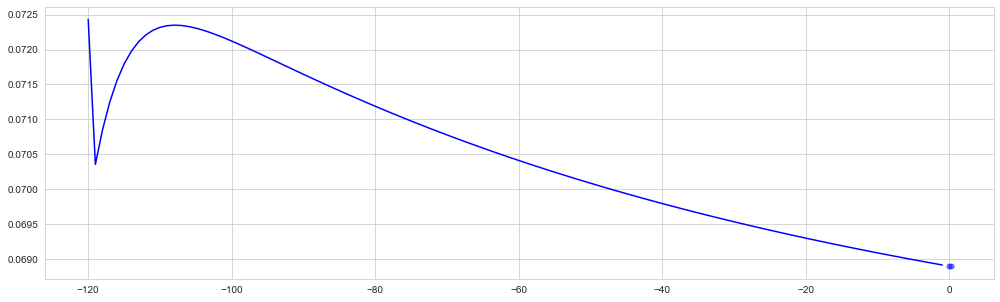

[8.62510e-07 2.20749e-08 4.51726e-08 6.62081e-08 8.60031e-08 1.04956e-07
 1.23271e-07 1.41059e-07 1.58381e-07 1.75272e-07]


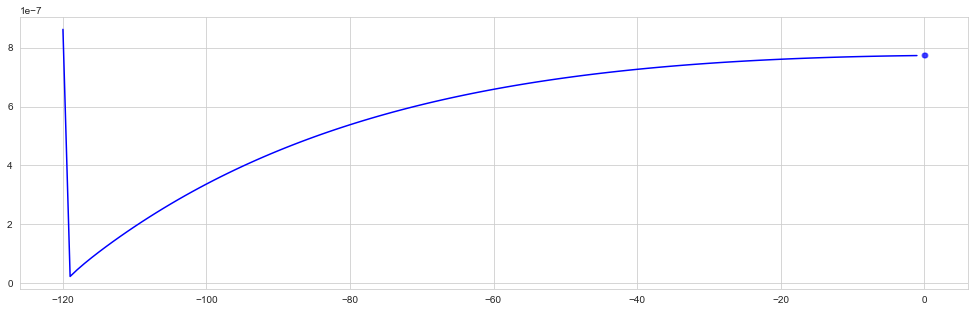

[0.0542412 0.0498828 0.0502639 0.050573  0.0508226 0.0510232 0.0511839
 0.0513119 0.0514134 0.0514932]


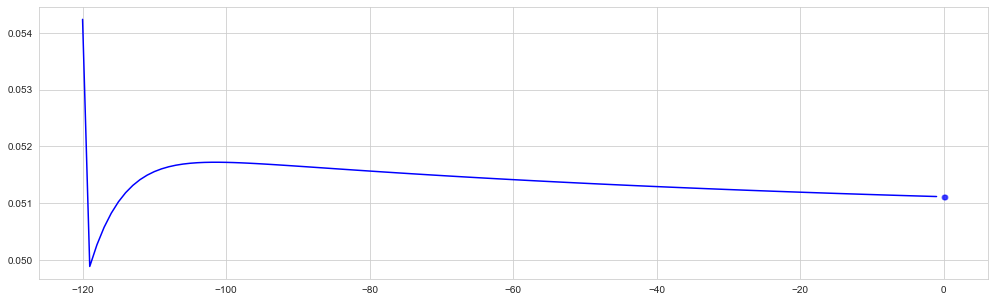

[1.25420e-07 1.85292e-09 9.84040e-09 2.38137e-08 4.21371e-08 6.23131e-08
 8.18618e-08 9.91319e-08 1.13530e-07 1.25229e-07]


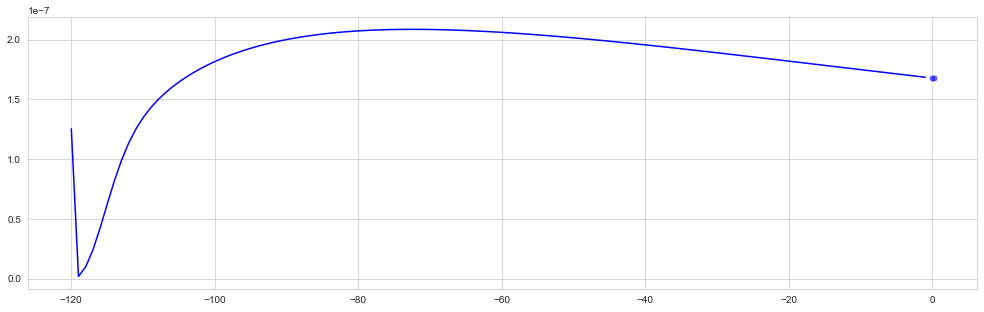

[4.21110e-04 3.92933e-06 8.90594e-06 1.40425e-05 1.92696e-05 2.45423e-05
 2.98304e-05 3.51125e-05 4.03733e-05 4.56013e-05]


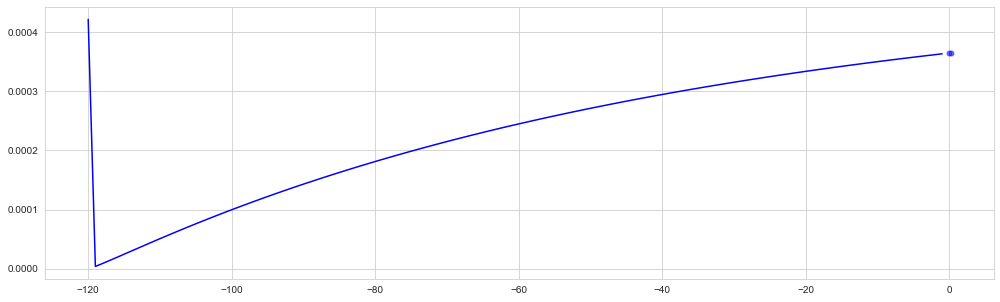

[8.31646e-03 5.35600e-05 1.18584e-04 1.84209e-04 2.50218e-04 3.16445e-04
 3.82765e-04 4.49084e-04 5.15334e-04 5.81466e-04]


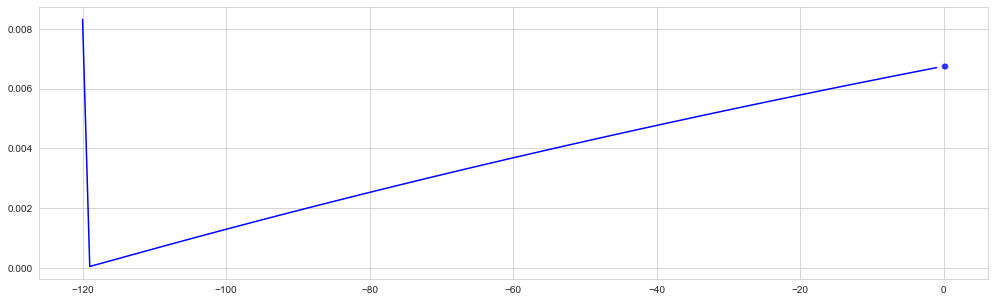

[6.59976e-06 1.05370e-07 2.87489e-07 4.80371e-07 6.78523e-07 8.79029e-07
 1.08000e-06 1.28016e-06 1.47859e-06 1.67467e-06]


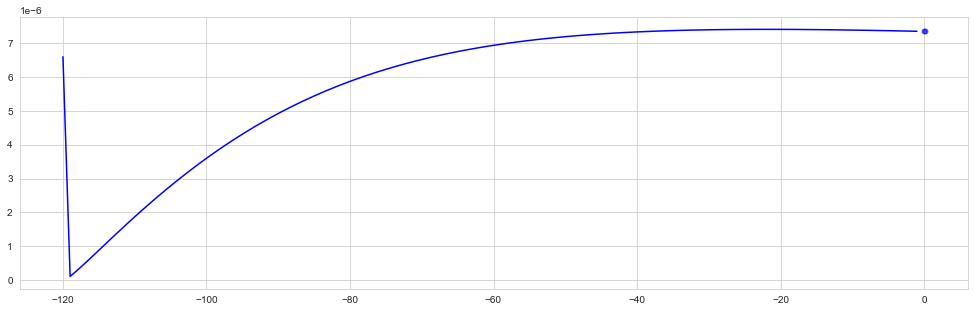

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


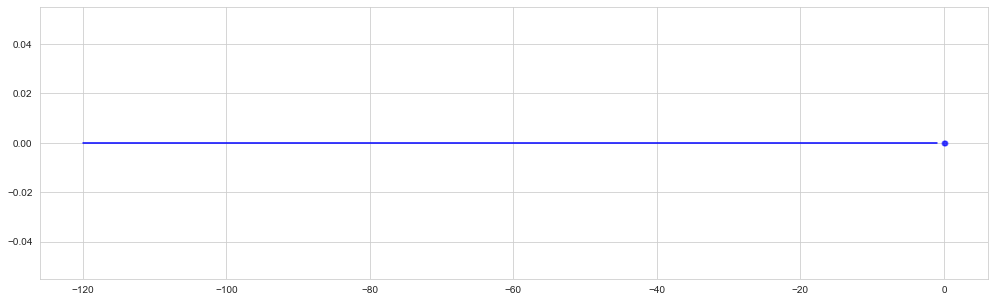

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


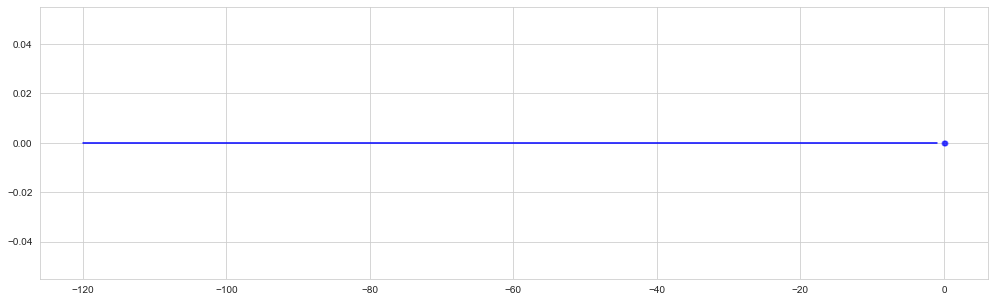

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


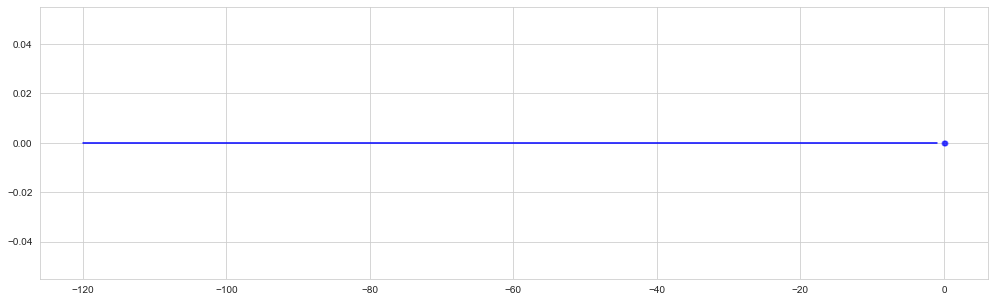

[0.0353263  0.00588859 0.0117839  0.0166042  0.0205351  0.0237337
 0.026332   0.0284399  0.0301482  0.0315315 ]


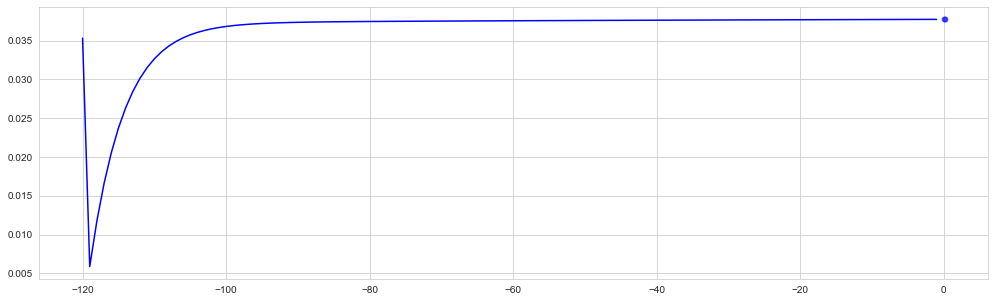

[0.0280714 0.0408439 0.0410825 0.0412601 0.0413873 0.0414731 0.041525
 0.0415494 0.0415514 0.0415354]


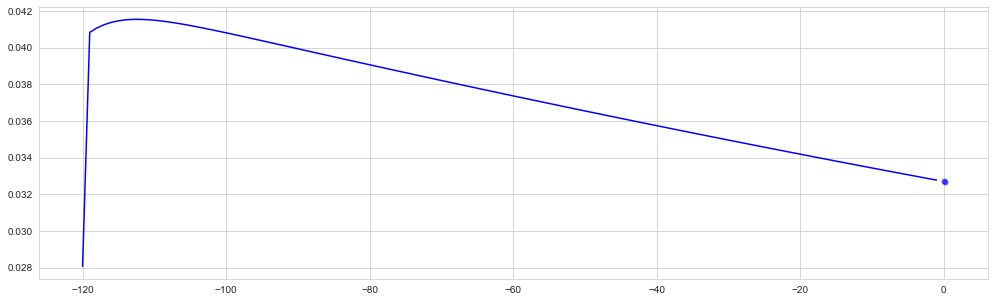

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


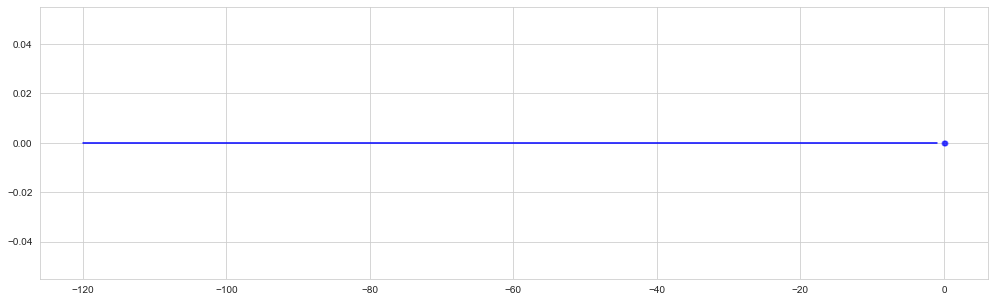

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


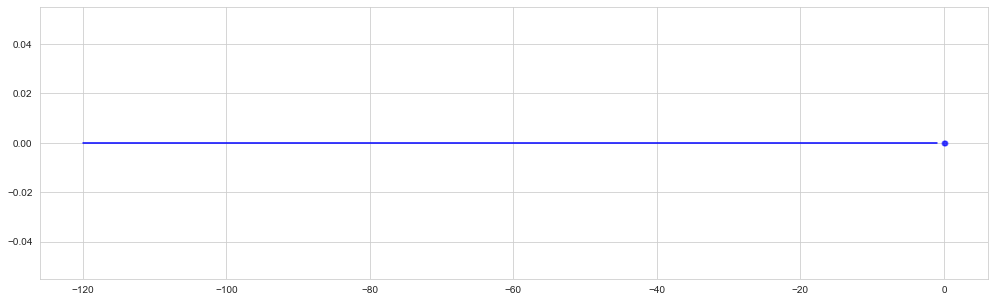

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


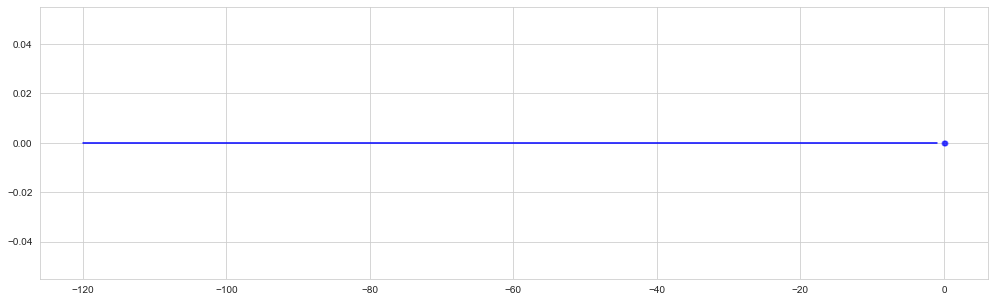

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


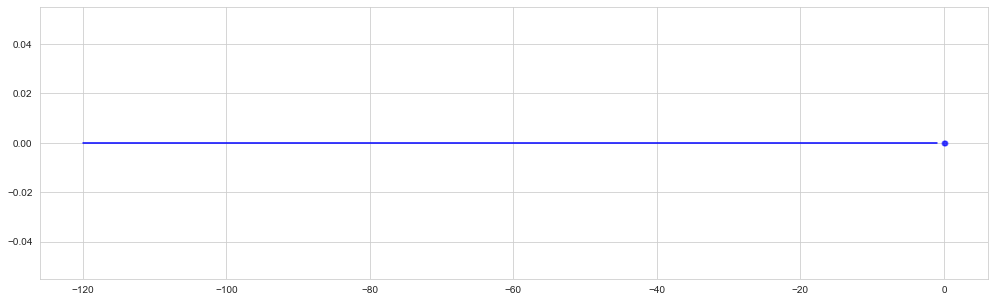

[3.73306e-10 4.87530e-07 3.39327e-07 2.09139e-07 1.26985e-07 7.69905e-08
 4.69363e-08 2.89939e-08 1.83270e-08 1.19996e-08]


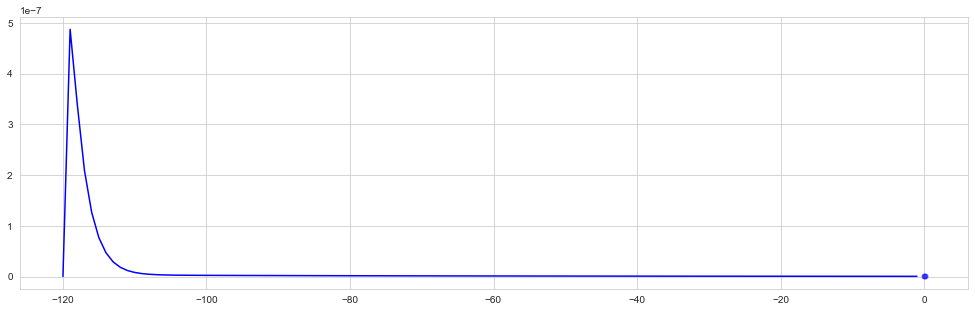

[5.05635e-05 1.55462e-02 9.30527e-03 5.57591e-03 3.35156e-03 2.02686e-03
 1.23885e-03 7.70513e-04 4.92311e-04 3.27085e-04]


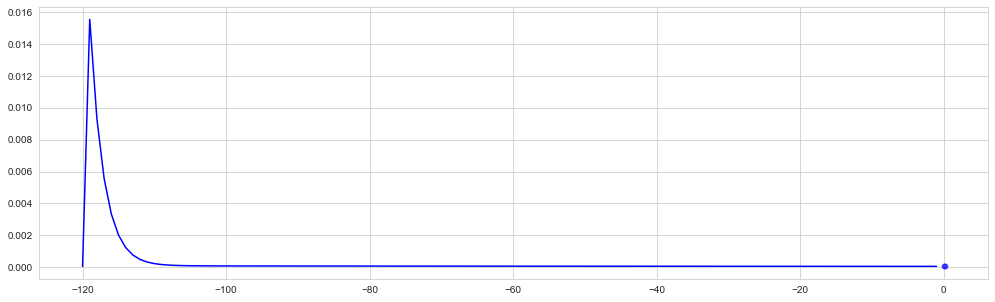

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


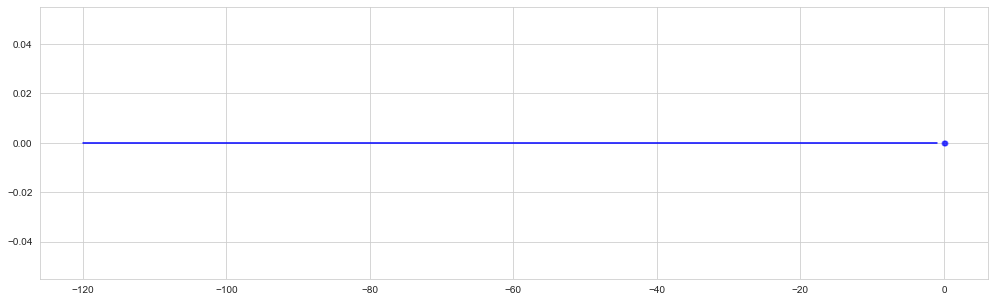

[0.187976 0.175495 0.176824 0.177899 0.178765 0.179459 0.180013 0.180451
 0.180796 0.181065]


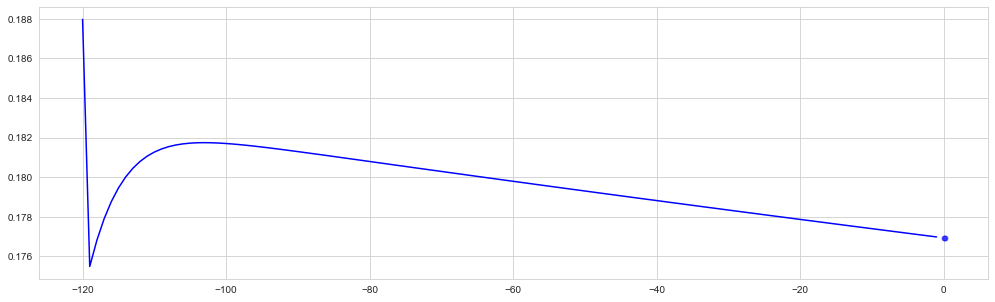

[8.90370e-03 4.94123e-05 1.10702e-04 1.73325e-04 2.36770e-04 3.00690e-04
 3.64841e-04 4.29048e-04 4.93190e-04 5.57178e-04]


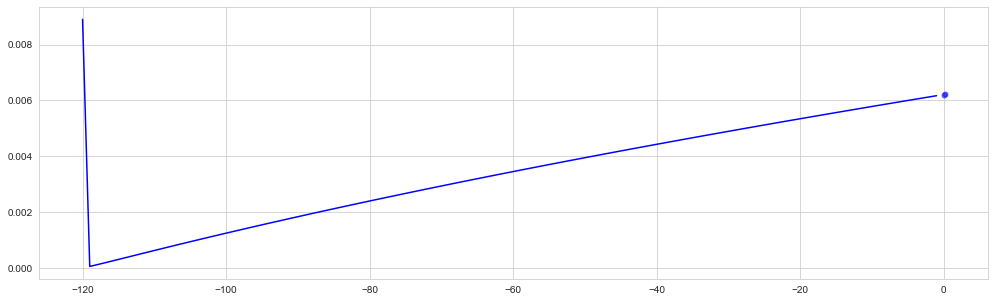

[0.        0.0700471 0.0568923 0.0461388 0.0373725 0.030242  0.0244524
 0.0197585 0.0159573 0.012882 ]


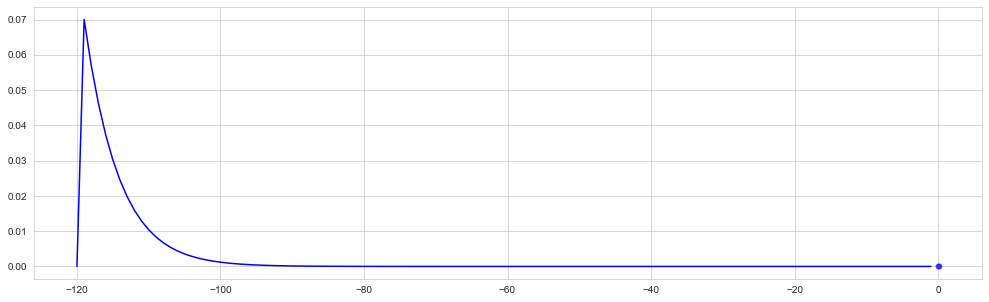

[8.76105e-07 4.05734e-08 8.71491e-08 1.31413e-07 1.73378e-07 2.13081e-07
 2.50578e-07 2.85941e-07 3.19255e-07 3.50607e-07]


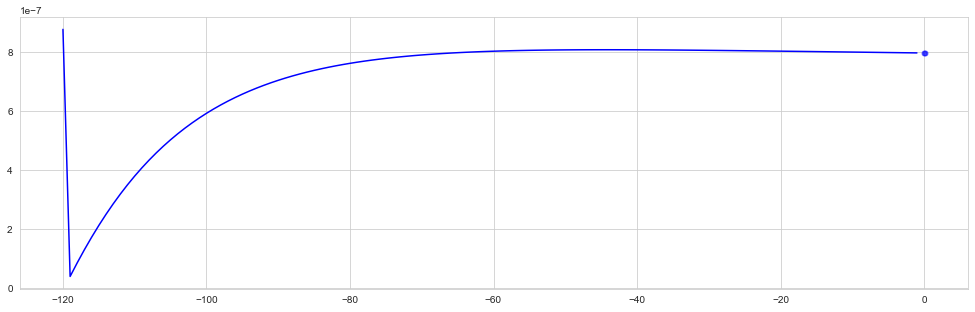

[0.00895206 0.00861065 0.00867069 0.00871877 0.00875687 0.00878672
 0.0088098  0.00882734 0.00884038 0.00884976]


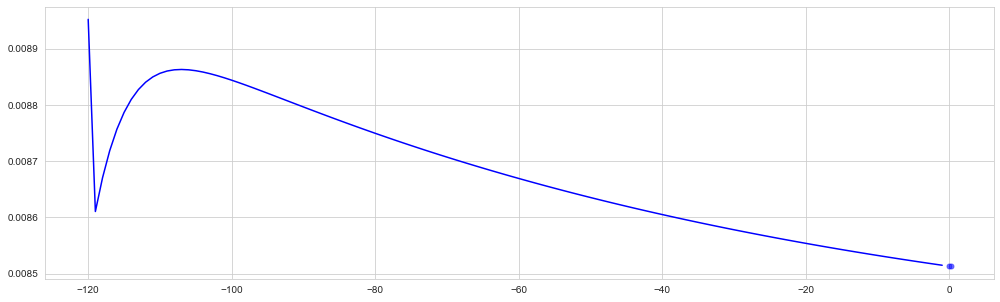

[2.48147e-11 1.27308e-10 1.32331e-10 1.35174e-10 1.36696e-10 1.37341e-10
 1.37386e-10 1.37011e-10 1.36339e-10 1.35453e-10]


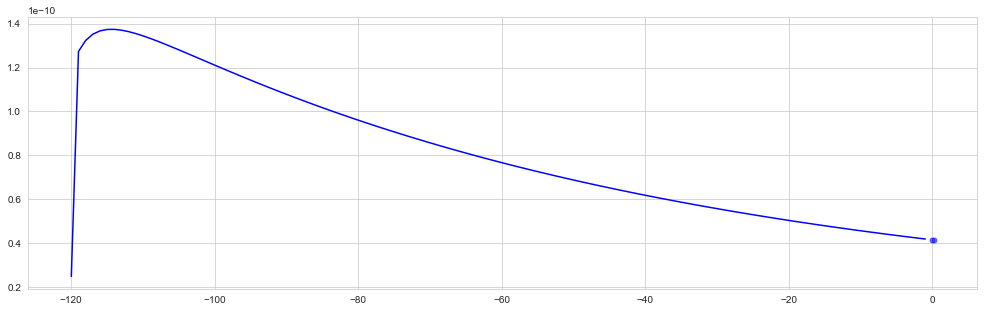

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


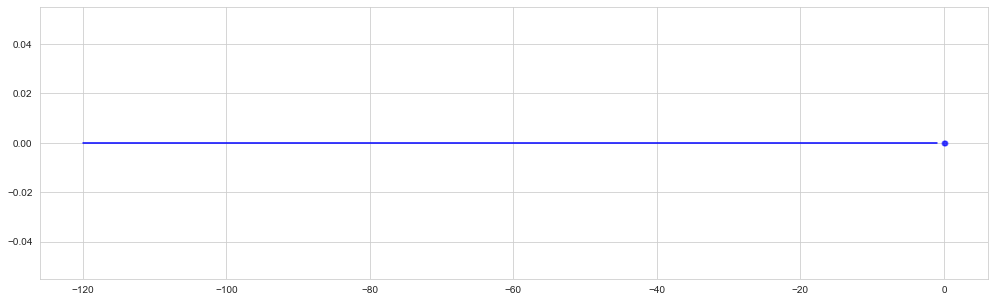

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


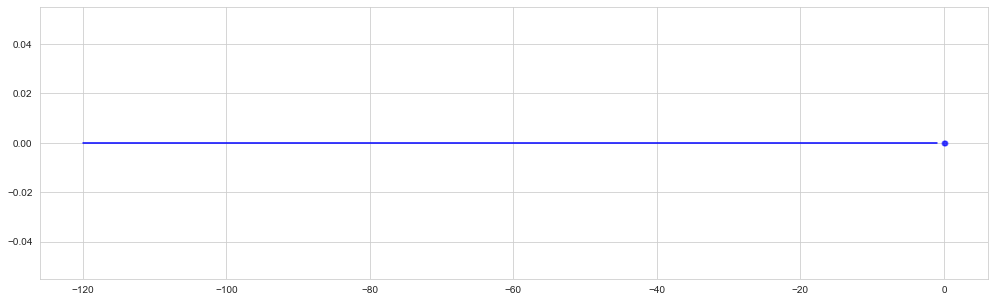

[0.0737864 0.0703671 0.0708753 0.0712804 0.0716008 0.0718517 0.0720459
 0.0721939 0.0723046 0.072385 ]


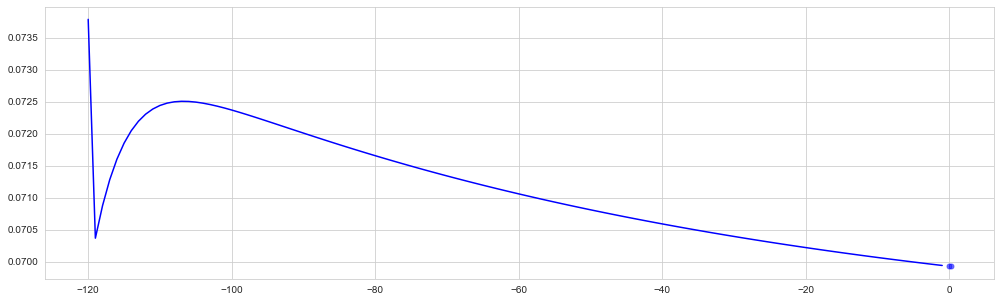

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


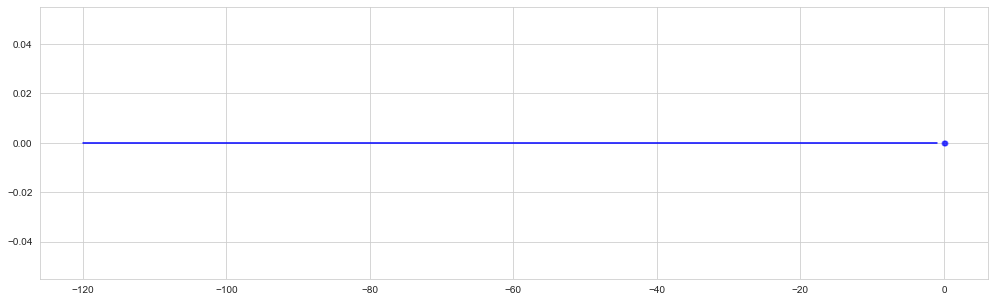

[0.0542412 0.0498828 0.0502639 0.050573  0.0508226 0.0510232 0.0511839
 0.0513119 0.0514134 0.0514932]


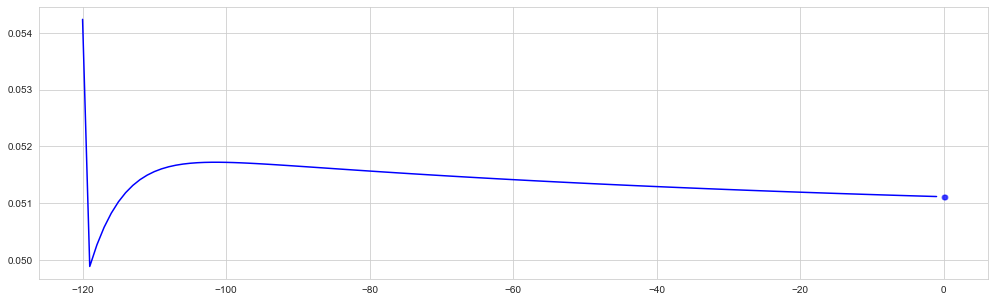

[0.141145 0.155868 0.163139 0.167641 0.170429 0.172146 0.173189 0.173801
 0.174134 0.174282]


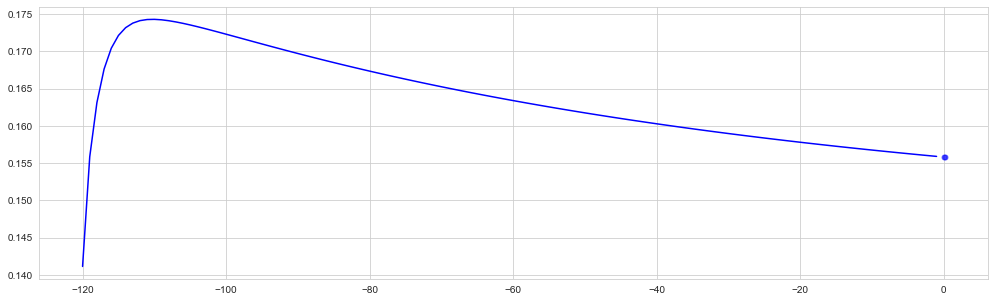

[7.29794e-12 3.22836e-11 3.13563e-11 3.09499e-11 3.07318e-11 3.05760e-11
 3.04320e-11 3.02797e-11 3.01120e-11 2.99272e-11]


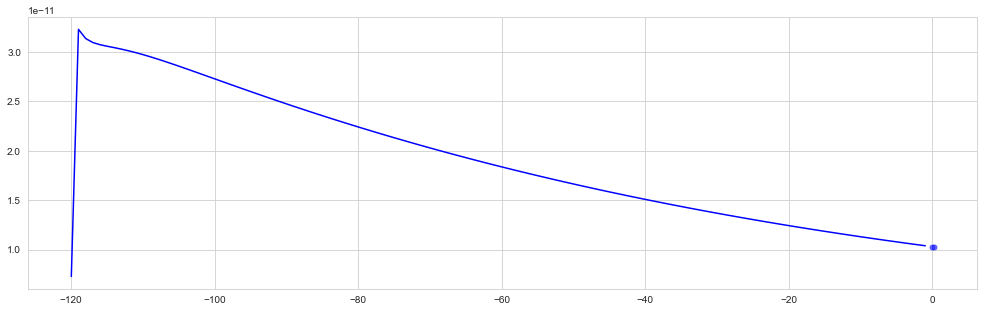

[5.05639e-05 1.55467e-02 9.30561e-03 5.57612e-03 3.35169e-03 2.02693e-03
 1.23890e-03 7.70542e-04 4.92329e-04 3.27097e-04]


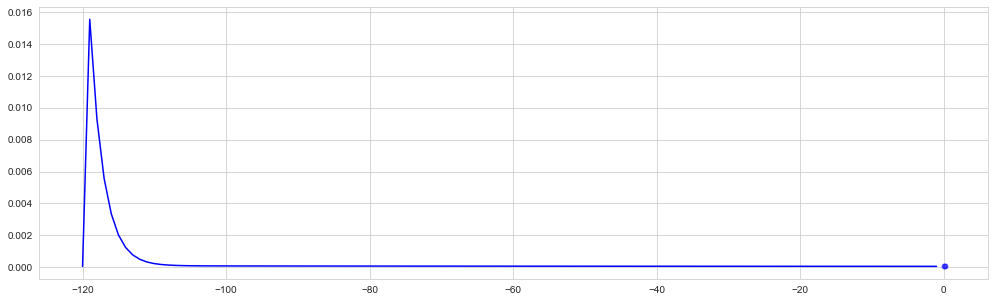

[1.53097e-03 1.34601e-05 3.11363e-05 4.97741e-05 6.89394e-05 8.83548e-05
 1.07841e-04 1.27284e-04 1.46608e-04 1.65767e-04]


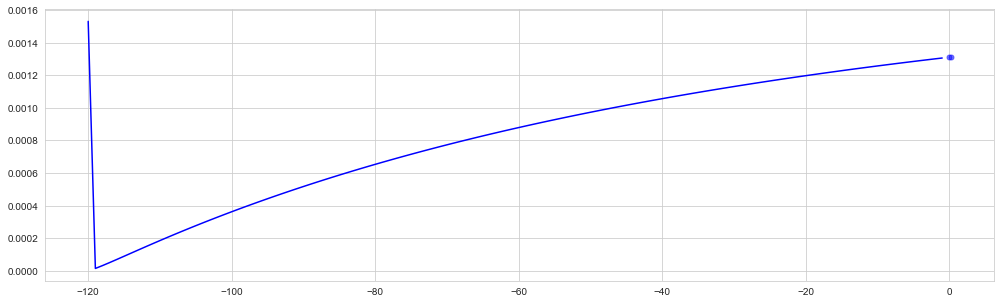

[0.00185197 0.0117101  0.0116558  0.0115849  0.0115007  0.0114061
 0.0113034  0.0111945  0.011081   0.0109641 ]


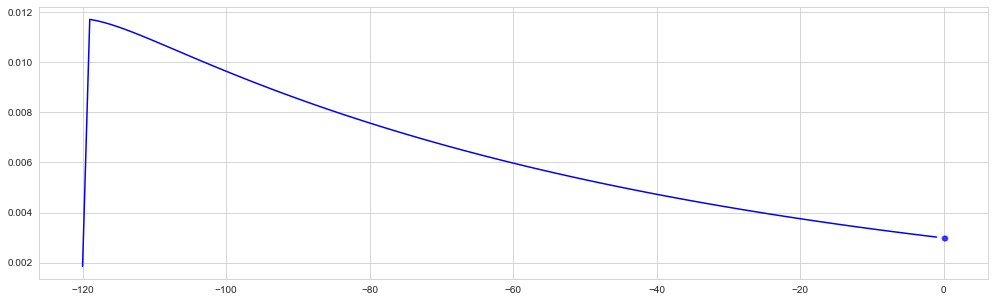

[0.0670191 0.0590435 0.0595206 0.0599132 0.0602358 0.0605009 0.0607188
 0.060898  0.0610457 0.0611677]


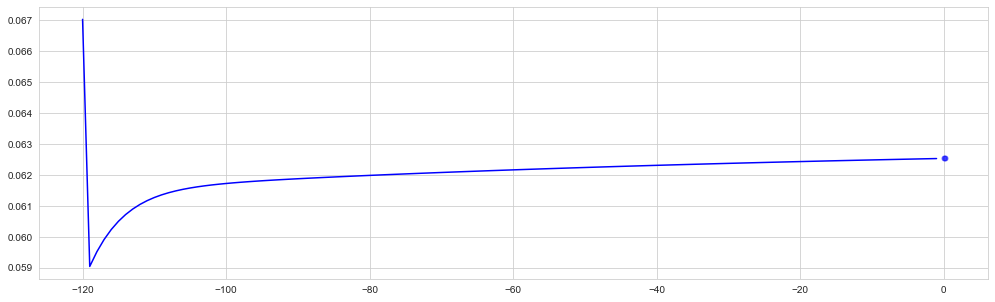

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


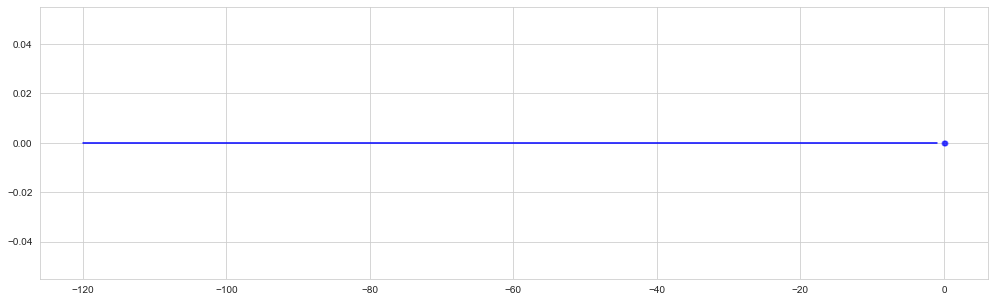

[1.25420e-07 1.85292e-09 9.84040e-09 2.38137e-08 4.21371e-08 6.23131e-08
 8.18618e-08 9.91319e-08 1.13530e-07 1.25229e-07]


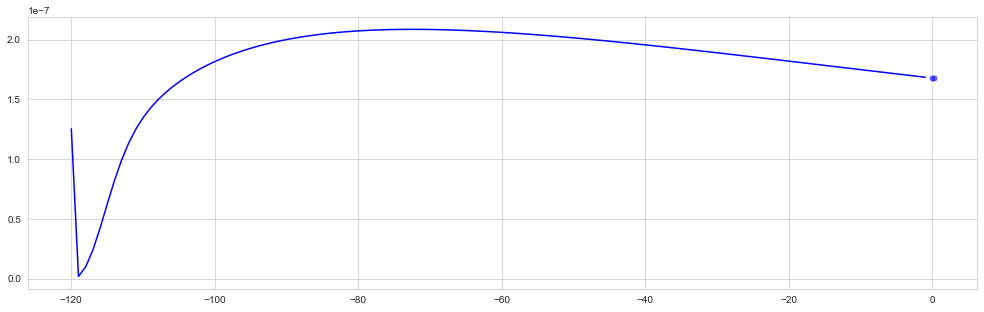

[0.207421 0.183806 0.185647 0.187238 0.188617 0.189819 0.190874 0.191808
 0.192641 0.19339 ]


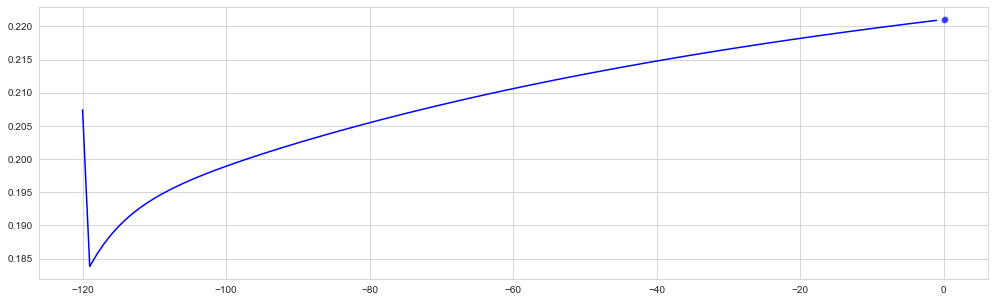

[8.74417e-03 5.75947e-05 1.27777e-04 1.98732e-04 2.70166e-04 3.41867e-04
 4.13675e-04 4.85477e-04 5.57186e-04 6.28742e-04]


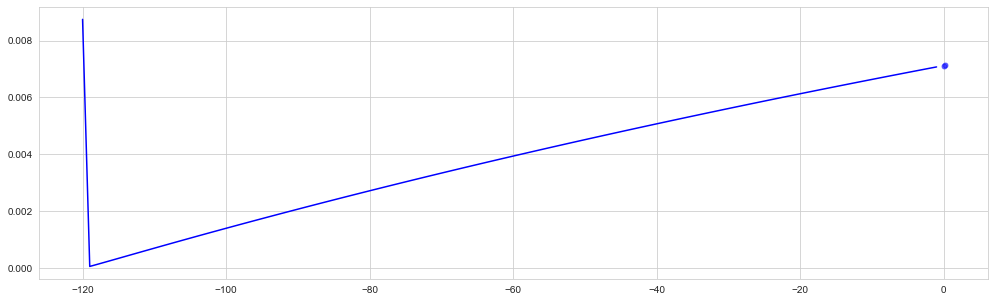

[0.0146296  0.00888912 0.00901875 0.00913579 0.00924219 0.00933963
 0.00942954 0.00951312 0.00959137 0.00966513]


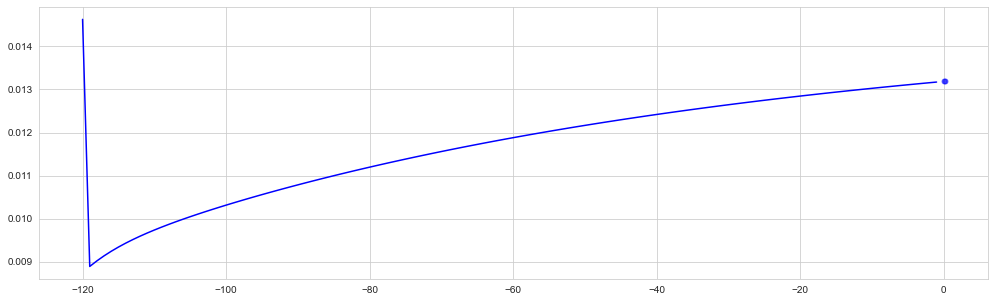

[0.0280714 0.0408439 0.0410825 0.0412601 0.0413873 0.0414731 0.041525
 0.0415494 0.0415514 0.0415354]


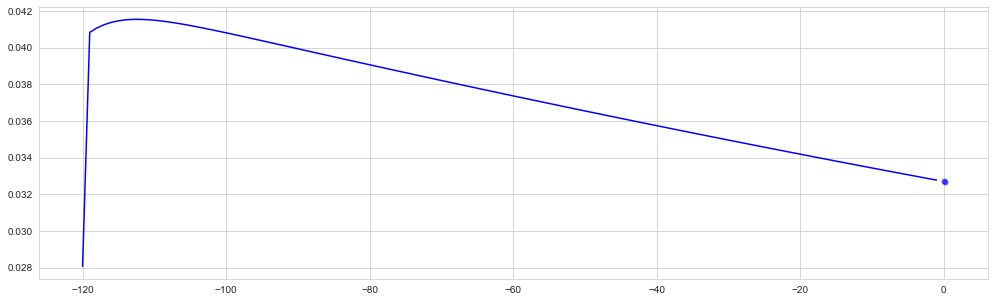

[0.19688  0.245592 0.233827 0.224211 0.216374 0.210002 0.20483  0.200639
 0.197246 0.194504]


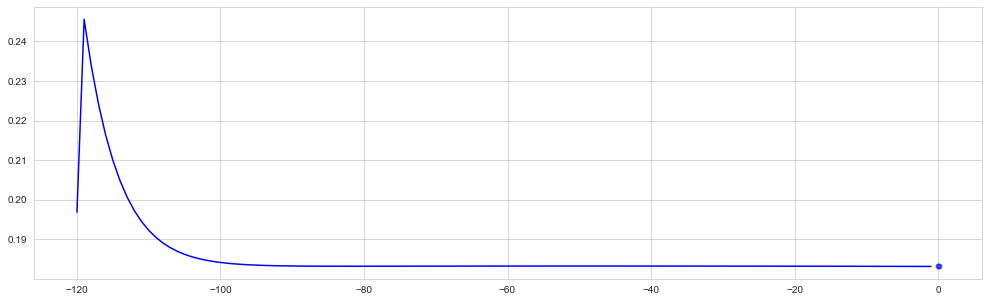

[0.169302 0.152492 0.153722 0.154734 0.155565 0.156247 0.156808 0.157268
 0.157647 0.15796 ]


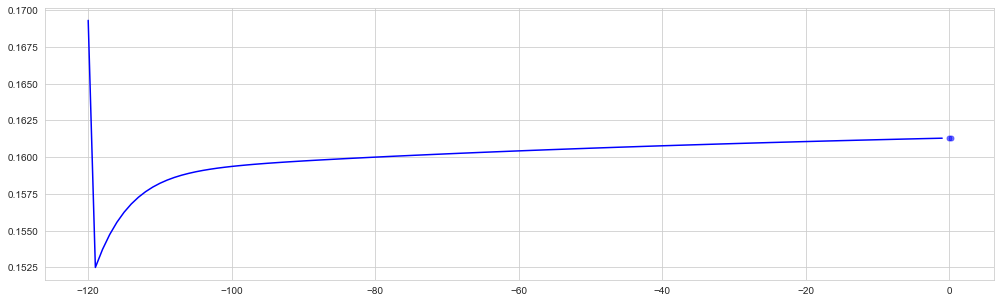

[0.0353263  0.00588859 0.0117839  0.0166042  0.0205351  0.0237337
 0.026332   0.0284399  0.0301482  0.0315315 ]


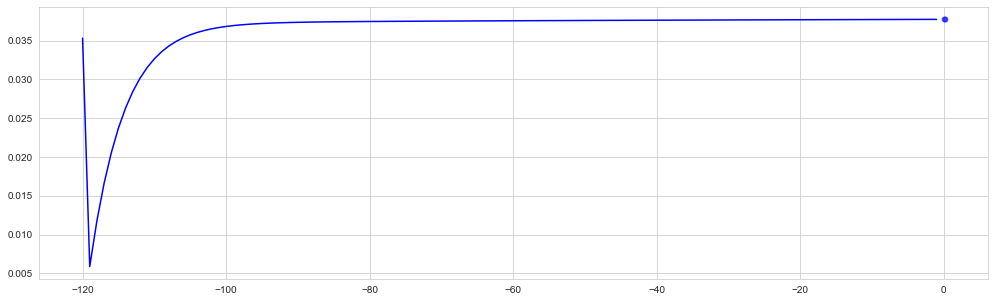

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


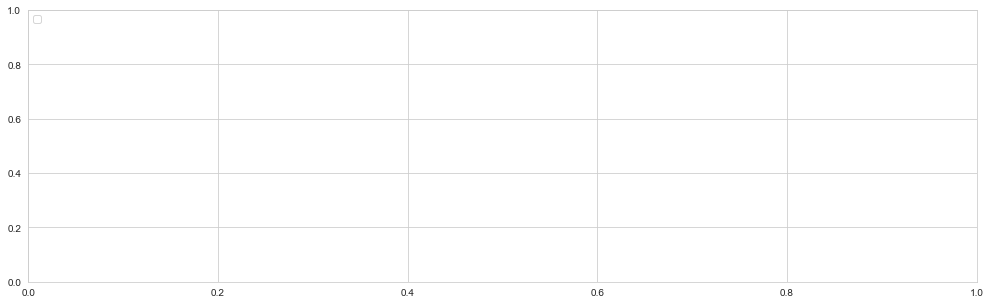

In [233]:
for x, y in val_data_multi.take(1):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.array([0]))

In [195]:
model = tf.keras.models.load_model('./multi-output-timesteps.h5')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

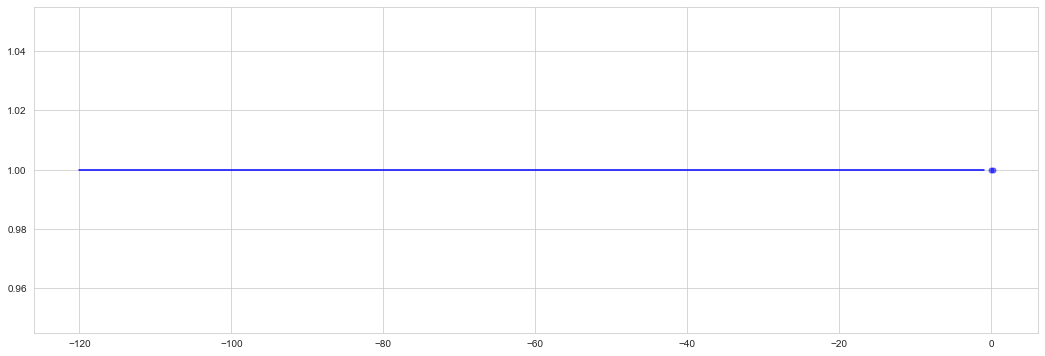

In [208]:
for x, y in val_data_multi.take(1):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))

In [199]:
pedict = np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:]))

In [205]:
pedict.shape

(68,)